### Daily R value derived from number of cases reported in LA county
Mehrdad Kiamari, Bhaskar Krishnamachari - June 2020

To monitor the severity of any epidemic, it is crucial to look at $R_t$ which is a value representing the effective reproduction number (the number of individuals who are infected per infectious individual at time $t$) of the disease. 

Regarding $R_t$, the epidemic will exponentially grow among the population when $R_t >> 1$. However, the epidemic sloowly disappear as $R_t<1$. Since restirctions would eventually impactts $R_t$, this measure can guide authorities to take appropriate actions regarding tightening or loosing restrictions for the sake of having economic prosperity and human safety.   

In this code, we aim at estimating daily R value of COVID-19 in LA county. Our approach is universal and can be utilized for any area. We use SIR model, i.e.

$$
\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N}\\
\frac{dI}{dt} &= +\beta \frac{SI}{N} - \sigma I\\
\frac{dR}{dt} &= \sigma I
\end{align}
$$

where $S$, $I$, and $R$ represent the number of Susceptible, Infected, and Recovered people in a population size of $N$. Regarding the parameter $\sigma = \frac{1}{D_i}$, $D_i$ represents the average infectious days.

As far as $R$ is concerned, it is equal to $\frac{\beta}{\sigma}$. Our idea is to estimate $\beta$ at each time from the above differential equation which involves $\frac{dI}{dt}$, then calculate the corresponding $R$.

In [1]:
import json
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
from matplotlib.colors import hsv_to_rgb
from itertools import combinations
import pandas as pd
import datetime as dt

from datetime import date 
from scipy.optimize import fsolve

from gekko import GEKKO
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

In [2]:
#target_comm = 'sangabriel'

Create a dictionary consisting of communities and their population as keys and values, respectively. 

In [3]:
with open('population.json') as json_file_pop:
	data_population = json.load(json_file_pop)

Function to check if the communitiy exists in the dictionary for population

In [4]:
def check_if_community_is_in_dic_pop(community_name):
	with open('population.json') as json_file_pop:
		data_population = json.load(json_file_pop)
		temp = [val for key,val in data_population.items() if community_name == key.strip().split('--')[0]]
		if len(temp)==1:
			#print(community_name,"found")
			return True
		#print(community_name,"NOT found")    
		return False

### Side Class and Functions

Each community is an object with few attributes such as name, number of daily or cumulative cases, etc.


In [5]:
def solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta,k):
#      
	if curr_I != 0:
# 		m = GEKKO()             # create GEKKO model
# 		beta = m.Var(value=1.0)      # define new variable, initial value=0
# 		m.Equations([(beta-sigma)*curr_I -  (beta/N)*(curr_I**2) == next_I - curr_I ]) # equations
# 		m.solve(disp=False)     # solve
# 		# not being negative
# 		output = max(beta.value[0],0)
		output = (next_I - curr_I+sigma*curr_I)/(curr_I-(k/N)*curr_I**2)
	else:
		output = prev_beta

	#print(beta.value[0])
	return output 	
def solve_beta_for_single_time_exponential(next_I,curr_I,sigma,N,prev_beta,k,cap_for_searching_exact_sol):

	#clear_output(wait=True)    
	#print("curr", curr_I, "next", next_I)
# 	if next_I != 0 and curr_I != 0 and next_I != curr_I:
# 		m = GEKKO()             # create GEKKO model
# 		beta = m.Var(value=1.0)      # define new variable, initial value=0
# 		m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0]) # equations
# 		m.solve(disp=False)     # solve
# 		output = beta.value[0]
# 	else:
# 		output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)
##################################
# 	data = (next_I,curr_I,sigma,N)
# 	beta_guess = .2
#	output = fsolve(function_for_solver, beta_guess, args=data)
#################################
	#cap_for_searching_exact_sol = 10
	output = max(0,solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta,k))
	if output > cap_for_searching_exact_sol and next_I != 0 and curr_I != 0 and next_I != curr_I:
		m = GEKKO()             # create GEKKO model
		beta = m.Var(value=1.0)      # define new variable, initial value=0
		m.Equations([((1/(beta-sigma))*m.log(k*next_I/((beta-sigma)-beta*k*next_I/N))) -  ((1/(beta-sigma))*m.log(k*curr_I/((beta-sigma)-beta*k*curr_I/N))) == 1.0]) # equations
		m.solve(disp=False)     # solve
		output = beta.value[0]  

	return output

def calculating_beta_for_a_comm(name,matrix_I,population,sigma,k,cap_for_searching_exact_sol):
#	print("confirmed cases: ",matrix_I)
# 	print(matrix_I.shape[1])
	c = matrix_I.shape[0]
	matrix_beta = np.zeros((c-1,))
	R = np.zeros((c-1,))
	#for city in range(r):
	#prev_beta = 0
	for time in range(c-1):
		#clear_output(wait=True)  
		#print("beta for city:",city)
		matrix_beta[time] = solve_beta_for_single_time_exponential(matrix_I[time+1],matrix_I[time],sigma,population,0,k,cap_for_searching_exact_sol) 
		#prev_beta = matrix_beta[city,time]
		R[time] = matrix_beta[time] / sigma
		#if name == target_comm:
		#	print(R[time], matrix_I[time+1],matrix_I[time])
	return R

#def moving_ave(matrix_I,n):
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [6]:
class community:
	def __init__(self,name,actual_name,Today_date):
		self.name = name
		self.Today_date = Today_date
		self.actual_name = actual_name # for displaying part of figures
		# cumulative total
		self.confirmed = np.zeros(len(range(16,self.Today_date)),dtype=int)
		self.confirmed_daily = np.zeros(len(range(16,self.Today_date)),dtype=int)
		self.infection_rate = np.zeros(len(range(16,self.Today_date-1)))
		self.risk = np.zeros(len(range(16,self.Today_date-1)))
		self.pop = 0

	def set_population(self,val):        
		self.pop = val
        
	def set_infection_rate(self,sigma,k,cap_for_searching_exact_sol):        
		self.infection_rate = calculating_beta_for_a_comm(self.name,self.confirmed_daily,self.pop,sigma,k,cap_for_searching_exact_sol)  

        
	def set_risk(self,day,val):
		self.risk[day] = val#(10000)*self.infection_rate[day]*self.confirmed_daily[day]/(self.pop-self.confirmed_daily[day])



	def smoothing(self,n=7):        
		#n=7      
		padded_I = np.zeros((1,len(self.confirmed_daily) + n-1 ))

		padded_I[0,(n-1)//2:-(n-1)//2]=self.confirmed_daily
		#for city in range(ref_matrix_I.shape[0]):
		self.confirmed_daily = movingaverage(padded_I[0,:],n)         
        
        
	# for adding new entry for each community on every day 	
	def check_validity_new_entry(self,day):
		index = day - 16
		if index == 0:
			return True
		else:
			if self.confirmed[index] >= self.confirmed[index-1]:
				return True
			return False		
	def update_confirmed_cases(self,day):
		#print("before")
		#print(self.confirmed)
		index = day - 16
		while index != 0:
			if self.confirmed[index] < self.confirmed[index-1]:
				self.confirmed[index-1] = self.confirmed[index]
			index -= 1
		#print("after")
		#print(self.confirmed)
	def addnumber(self,day, number):
		index = day - 16
		self.confirmed[index] = number
		status_validity_of_entry = self.check_validity_new_entry(day)
		if not status_validity_of_entry:
			self.update_confirmed_cases(day)

	# return the confirmed cases (either daily or cumulative) for each community		
	def plot_info(self,type_plot):
		output = np.zeros(len(range(16,self.Today_date)),dtype=int)
		for index,i in enumerate(list(range(16,self.Today_date))):
			# for daily
			if type_plot == 'daily':
				# if i in self.dic_confirmed.keys():
				# 	output[index] =  self.dic_confirmed[i]
				# else:
				# 	output[index] = 0
				output = self.confirmed_daily
			# for cumulative
			else:
				output = self.confirmed
		return output	

# get population for top selected communities    
def get_population_vec(list_communities):
	with open('population.json') as json_file_pop:
		data = json.load(json_file_pop)

		output_list = []
		for communiuty_obj in list_communities:
			#print("comm name",communiuty_obj.name)
			temp = [val for key,val in data.items() if communiuty_obj.actual_name == key.strip().split('--')[0]]
			if temp :
		 		output_list.append(int(temp.pop().strip()))
		if len(output_list) == len(list_communities):
			output = np.asarray(output_list)
		else:
			raise NameError('The name of one of communities has NOT been found!')	

		return output

def create_matrix_with_dict_as_input(dict_selected_communities,type_plot,til_date):
	# matrix_I  has c rows (communities) and T columns (days) 
	#matrix_I =  np.zeros((len(list_selected_communities),len(range(16,list_selected_communities[0].Today_date)) ))
	matrix_I =  np.zeros((len(dict_selected_communities),til_date ))
	i =0
	for communiuty_obj in  dict_selected_communities.keys():
		I_s_this_community_obj = communiuty_obj.plot_info(type_plot)[:til_date]
		#print("row", i, communiuty_obj.name)
		for j,infected_at_this_day in enumerate(I_s_this_community_obj):
			matrix_I[i,j] = infected_at_this_day
			dict_selected_communities[communiuty_obj].append(i)            
		i += 1
	return dict_selected_communities, matrix_I
    
    
# create matrix for number of infections for top selected communities    
def create_matrix(list_selected_communities,type_plot,til_date):
	# matrix_I  has c rows (communities) and T columns (days) 
	#matrix_I =  np.zeros((len(list_selected_communities),len(range(16,list_selected_communities[0].Today_date)) ))
	matrix_I =  np.zeros((len(list_selected_communities),til_date ))
	for i,communiuty_obj in  enumerate(list_selected_communities):
		I_s_this_community_obj = communiuty_obj.plot_info(type_plot)[:til_date]
		#print("row", i, communiuty_obj.name)
		for j,infected_at_this_day in enumerate(I_s_this_community_obj):
			 matrix_I[i,j] = infected_at_this_day
	return matrix_I	 

# matrix I is supposed to be increasing for each community, so we fix any drop by this function
def fix_matrix_I(matrix_I):
    output = np.zeros_like(matrix_I)
    output[:,0] = matrix_I[:,0]
    r,c = matrix_I.shape[0], matrix_I.shape[1]
    for ind_r in range(r):
        for ind_c in range(1,c):
            if matrix_I[ind_r,ind_c] < matrix_I[ind_r,ind_c-1]:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c-1]
            else:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c]
    return output            

### Load CSV File

In [7]:
states1 = pd.read_csv('Covid-19.csv', usecols=[0,1,4],
                     index_col=['Region', 'Time Stamp'],
                     parse_dates=['Time Stamp'],
                     squeeze=True).sort_index()
states = states1.groupby(['Region', 'Time Stamp']).sum()
states.head()
#print(states['Melrose']['2020-03-16'])

Region  Time Stamp
Acton   2020-03-28    0
        2020-03-29    0
        2020-03-30    0
        2020-03-31    0
        2020-04-01    0
Name: Number of cases, dtype: int64

### Create DataFrame 
Make DataFrame for R

In [8]:
def create_dataframe_for_R(ind_city,matrix_beta,sigma,U,D):  
    r,c = matrix_beta.shape[0],matrix_beta.shape[1]
    data={}
    data['R'] = matrix_beta[ind_city,:]/sigma
    data['Upper'] = U[ind_city,:]
    data['Lower'] = D[ind_city,:]
    #print(len(data['R']),len(data['Upper']),len(data['Lower']))
    data['Time Stamp'] = pd.date_range(start='2020-03-16', periods=c)    
    dataset = pd.DataFrame(data)
    dataset.set_index(['Time Stamp'], inplace=True)    
    #print(dataset)
    return dataset    

### Plot Func for R

In [9]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['R'].index.get_level_values('Time Stamp')
    values = result['R'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Lower'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['Upper'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-16'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,10.0)
    ax.set_xlim(pd.Timestamp('2020-03-16'), result.index.get_level_values('Time Stamp')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')


    


Setting for mean and var PDF's

In [10]:
mean_D = 7.5
var_D = 1.0

min_k_value = 1.0
max_k_value = 10.0
mean_k = .5*(min_k_value+max_k_value)
# with .997% CI
var_k = ((max_k_value-mean_k)/3)**2

cap_for_searching_exact_sol = 10

### Histogram - used for finding thresholds

In [11]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

In [12]:
# def histogram_risk_score(communities):
# 	ava_communities=[]
# 	for comm in communities:
# 		if available_in_pop(comm):
# 			ava_communities.append(comm)
# 	num_day_to_investigate = len(ava_communities[0].confirmed_daily) - 1
# 	#risk_score_a_day = np.zeros((len(ava_communities),num_day_to_investigate))
# 	data_risk , labels = []  , [] 
# 	for day in range(66,67):#num_day_to_investigate):
# 		risk_score_a_day = np.zeros(len(ava_communities))
# 		for ind, comm in enumerate(ava_communities):
# 			risk_score_a_day[ind] = (comm.infection_rate[day]*comm.confirmed_daily[day]/(get_population_vec([comm])-comm.confirmed_daily[day]))
# 		min_r , max_r = np.min(risk_score_a_day),np.max(risk_score_a_day)
# 		range_r = np.arange(min_r,max_r,(max_r-min_r)/100.0)
#         #[10, 2.5, 3, 4,5,6,7,8,9,10]
# 		plt.hist(data_risk, bins=range_r, density=False)
# 		data_risk.append(risk_score_a_day)
# 		#labels.append(day)
# 	#plt.boxplot(data_risk[65:70],showfliers=False)
# 	#bp = plt.boxplot(data_risk,labels)#showfliers=False) 
# 	#df = get_box_plot_data(labels, bp)
# 	#hist_thresholds = df.mean()
# 	#print("hist_thresholds\n",hist_thresholds[0],hist_thresholds[1],hist_thresholds[2],hist_thresholds[3])
# 	plt.show()
# 	#return hist_thresholds

In [13]:
def histogram_risk_score(communities):
	ava_communities=[]
	for comm in communities:
		if available_in_pop(comm):
			ava_communities.append(comm)
	num_day_to_investigate = len(ava_communities[0].confirmed_daily) - 1
	#risk_score_a_day = np.zeros((len(ava_communities),num_day_to_investigate))
	data_risk , labels = []  , [] 
	for day in range(65,66):#num_day_to_investigate):
		risk_score_a_day = np.zeros(len(ava_communities))
		for ind, comm in enumerate(ava_communities):
			risk_score_a_day[ind] = (comm.infection_rate[day]*comm.confirmed_daily[day]/(get_population_vec([comm])-comm.confirmed_daily[day]))
		min_r , max_r = np.min(risk_score_a_day),np.max(risk_score_a_day)
		range_r = np.arange(min_r,max_r,(max_r-min_r)/100.0)
        #[10, 2.5, 3, 4,5,6,7,8,9,10]
		plt.hist(risk_score_a_day, bins=range_r, density=False)
		data_risk.append(risk_score_a_day)
		labels.append(day)
#	plt.boxplot(data_risk[65:70],showfliers=False)
	bp = plt.boxplot(data_risk,labels)#showfliers=False) 
#	df = get_box_plot_data(labels, bp)
#	hist_thresholds = df.mean()
#	print("hist_thresholds\n",hist_thresholds[0],hist_thresholds[1],hist_thresholds[2],hist_thresholds[3])
	plt.show()
#	return hist_thresholds

In [14]:
def decide_level(val,thresholds):
    if val < thresholds[1]:
        return 0
    elif thresholds[1]<val and val<=thresholds[2]:
        #import pdb;pdb.set_trace()
        return 1
    
    elif thresholds[2]<val and val<=thresholds[3]:
        return 2
    #elif thresholds[2]<val and val<=thresholds[3]:
    else:
        return 3

Update CSV file (replace density with infection rate)

In [15]:
def available_in_pop(obj):
    with open('population.json') as json_file_pop:
        data_population = json.load(json_file_pop)
        temp = [val for key,val in data_population.items() if obj.actual_name == key.strip().split('--')[0]]
        if len(temp)==1:
            #print(community_name,"found")
            return True
        #print(community_name,"NOT found")    
        return False

### For ESTIMATION of risk score of all communities

In [16]:
def update_csv_file(dict_comm,thresholds):
    #begining_date = date(2020, 3, 16)
    data_map = pd.read_csv('Covid-19-density.csv')
    
    data_map['Date'] = pd.to_datetime(data_map['Time Stamp'], format='%m-%d-%Y')
    data_map['Date-Start'] = '03-16-2020'
    data_map['Date-Start'] = pd.to_datetime(data_map['Date-Start'], format='%m-%d-%Y')
    data_map['Time-Index'] = (data_map['Date']-data_map['Date-Start']).dt.days
    data_map['Risk-Score'] = -1.0
    data_map['Risk-Level'] = -1
    #data_map.head(20)
    #print(data_map['date'])
    #return 0
    for ind in data_map.index: 
        # getting name of comm and do regular expressions
        city = data_map['Region'][ind]
        processed_city = city.strip().lower().replace(' ','')
        prefixex = ['cityof','losangeles-','unincorporated-']
        for word in prefixex:
            name_of_community = processed_city.replace(word,'')
        # get day
        day = data_map['Time-Index'][ind]
        #print(day,type(day))
        comm_obj = dict_comm[name_of_community]
        if day >= len(comm_obj.infection_rate):
            data_map.drop(ind)
        else:
        #print(len(comm_obj.infection_rate))
            #print("-->",comm_obj.name)
            #curr_comm = []
            #curr_comm.append(comm_obj)
            ####not_found_list = ['avalon','parklabrea','baldwinpark','bassett']
            if available_in_pop(comm_obj):
                data_map['Risk-Score'][ind] = (10000)*comm_obj.infection_rate[day]*comm_obj.confirmed_daily[day]/(get_population_vec([comm_obj])-comm_obj.confirmed_daily[day])
                data_map['Risk-Level'][ind] = decide_level(data_map['Risk-Score'][ind],thresholds)
        #- begining_date).dt.days 
        #print(day,type(day))
        #ind_day = row['Time Stamp'] - begining_date
        #print(ind_day,row['Time Stamp'])
    #print(data_map[data_map['Risk-Level']==3])
    print(data_map.loc[data_map['Risk-Score'] == -1.0].Region.unique())
    data_map.to_csv('Covid-19-R.csv', columns = ['Time Stamp','Region','Latitude','Longitude','Risk-Score','Risk-Level'])
    #print(data_map)

### For PREDICTION of risk score of all communities

In [17]:
def pred_R_LA(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]
    #x = np.arange(number_last_days_to_use)
    #y_pred = np.zeros((num_day_to_pred,))
    #for city in range(num_cities):
    print(matrix_beta.shape)
    y = matrix_beta[0,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
    x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("shape beta",matrix_beta.shape, ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("len(x)",len(x))
    print("matrix_beta.shape[1]",matrix_beta.shape[1],'\n',len(y))
    #coeff = np.polynomial.polynomial.polyfit(x, y, poly_degree)
    coeff = np.polyfit(x, y,1)#, 1, w = np.arange(x))
    model = np.poly1d(coeff)
    #for ind_future in range(num_day_to_pred):
    #    pred_y[ind_future] = model(number_last_days_to_use+ind_future)
    #plt.plot(np.arange(num_days),matrix_beta[city,:],'o-r')
    x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print(x_future,model(x_future))
    return model(x_future)

In [18]:
def update_csv_file_PREDICTION(dict_comm,thresholds):
    #begining_date = date(2020, 3, 16)
    data_map = pd.read_csv('Covid-19-density.csv')
    
    data_map['Date'] = pd.to_datetime(data_map['Time Stamp'], format='%m-%d-%Y')
    data_map['Date-Start'] = '03-16-2020'
    data_map['Date-Start'] = pd.to_datetime(data_map['Date-Start'], format='%m-%d-%Y')
    data_map['Time-Index'] = (data_map['Date']-data_map['Date-Start']).dt.days
    data_map['Risk-Score'] = -1.0
    data_map['Risk-Level'] = -1
    #data_map.head(20)
    #print(data_map['date'])
    #return 0
    for ind in data_map.index: 
        # getting name of comm and do regular expressions
        city = data_map['Region'][ind]
        processed_city = city.strip().lower().replace(' ','')
        prefixex = ['cityof','losangeles-','unincorporated-']
        for word in prefixex:
            name_of_community = processed_city.replace(word,'')
        # get day
        day = data_map['Time-Index'][ind]
        #print(day,type(day))
        comm_obj = dict_comm[name_of_community]
        if day >= len(comm_obj.infection_rate):
            data_map.drop(ind)
        else:
        #print(len(comm_obj.infection_rate))
            #print("-->",comm_obj.name)
            #curr_comm = []
            #curr_comm.append(comm_obj)
            ####not_found_list = ['avalon','parklabrea','baldwinpark','bassett']
            if available_in_pop(comm_obj):
                data_map['Risk-Score'][ind] = comm_obj.risk[day]#(10000)*comm_obj.infection_rate[day]*comm_obj.confirmed_daily[day]/(get_population_vec([comm_obj])-comm_obj.confirmed_daily[day])
                data_map['Risk-Level'][ind] = decide_level(data_map['Risk-Score'][ind],thresholds)
        #- begining_date).dt.days 
        #print(day,type(day))
        #ind_day = row['Time Stamp'] - begining_date
        #print(ind_day,row['Time Stamp'])
    #print(data_map[data_map['Risk-Level']==3])
    print(data_map.loc[data_map['Risk-Score'] == -1.0].Region.unique())
    data_map.to_csv('Covid-19-R-Prediction.csv', columns = ['Time Stamp','Region','Latitude','Longitude','Risk-Score','Risk-Level'])
    #print(data_map)

### Histogram of Risk Scores across Communities

In [19]:
# def get_box_plot_data(labels, bp):
#     rows_list = []

#     for i in range(len(labels)):
#         dict1 = {}
#         dict1['label'] = labels[i]
#         dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
#         dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
#         dict1['median'] = bp['medians'][i].get_ydata()[1]
#         dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
#         dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
#         rows_list.append(dict1)

#     return pd.DataFrame(rows_list)

In [20]:
# def histogram_risk_score(communities):
# 	ava_communities=[]
# 	for comm in communities:
# 		if available_in_pop(comm):
# 			ava_communities.append(comm)
# 	num_day_to_investigate = len(ava_communities[0].confirmed_daily) - 1
# 	#risk_score_a_day = np.zeros((len(ava_communities),num_day_to_investigate))
# 	data_risk , labels = []  , [] 
# 	for day in range(num_day_to_investigate):
# 		risk_score_a_day = np.zeros(len(ava_communities))
# 		for ind, comm in enumerate(ava_communities):
# 			risk_score_a_day[ind] = (comm.infection_rate[day]*comm.confirmed_daily[day]/(get_population_vec([comm])-comm.confirmed_daily[day]))
# 		min_r , max_r = np.min(risk_score_a_day),np.max(risk_score_a_day)
# 		range_r = np.arange(min_r,max_r,(max_r-min_r)/100.0)
#         #####[10, 2.5, 3, 4,5,6,7,8,9,10]
#         #####plt.hist(risk_score_a_day, bins=range_r, density=False)
# 		data_risk.append(risk_score_a_day)
# 		labels.append(day)
# #####plt.boxplot(data_risk,showfliers=False)
# 	bp = plt.boxplot(data_risk,labels)#showfliers=False) 
# 	df = get_box_plot_data(labels, bp)
# 	hist_thresholds = df.mean()
# 	print("hist_thresholds\n",hist_thresholds[2],type(hist_thresholds))
# 	plt.show()
# 	return hist_thresholds

In [21]:
def histogram_risk_score(communities):
	ava_communities=[]
	for comm in communities:
		if available_in_pop(comm):
			ava_communities.append(comm)
	num_day_to_investigate = len(ava_communities[0].confirmed_daily) - 1
	#risk_score_a_day = np.zeros((len(ava_communities),num_day_to_investigate))
	data_risk , labels = []  , [] 
	for day in range(num_day_to_investigate-2,num_day_to_investigate-1):
		risk_score_a_day = np.zeros(len(ava_communities))
		for ind, comm in enumerate(ava_communities):
			#risk_score_a_day[ind] = comm.infection_rate[day]
			risk_score_a_day[ind] = (10000)*(comm.infection_rate[day]*comm.confirmed_daily[day]/(get_population_vec([comm])-comm.confirmed_daily[day]))
		min_r , max_r = np.min(risk_score_a_day),np.max(risk_score_a_day)
		range_r = np.arange(min_r,max_r+1.0,(max_r-min_r)/100.0)
        #####[10, 2.5, 3, 4,5,6,7,8,9,10]
		plt.hist(risk_score_a_day, bins=range_r, density=False)
	plt.title('Histogram of Risk Score')  
	plt.ylabel('Frequency of Communities') 
	plt.xlabel('Risk Score')    
	plt.show()
	#return hist_thresholds

In [22]:
def histogram_R_val(communities):
	ava_communities=[]
	for comm in communities:
		if available_in_pop(comm):
			ava_communities.append(comm)
	num_day_to_investigate = len(ava_communities[0].confirmed_daily) - 1
	#risk_score_a_day = np.zeros((len(ava_communities),num_day_to_investigate))
	data_risk , labels = []  , [] 
	for day in range(num_day_to_investigate-2,num_day_to_investigate-1):
		risk_score_a_day = np.zeros(len(ava_communities))
		for ind, comm in enumerate(ava_communities):
			risk_score_a_day[ind] = comm.infection_rate[day]
			#risk_score_a_day[ind] = (10000)*(comm.infection_rate[day]*comm.confirmed_daily[day]/(get_population_vec([comm])-comm.confirmed_daily[day]))
		min_r , max_r = np.min(risk_score_a_day),np.max(risk_score_a_day)
		range_r = np.arange(min_r,max_r+1.0,(max_r-min_r)/100.0)
        #####[10, 2.5, 3, 4,5,6,7,8,9,10]
		plt.hist(risk_score_a_day, bins=range_r, density=False)
	plt.title('Histogram of $R_t$')  
	plt.ylabel('Frequency of Communities') 
	plt.xlabel('$R_t$')    
	plt.show()
	#return hist_thresholds

In [23]:
# def decide_level(val,thresholds):
#     if val<=thresholds[0]:
#         return 0
#     elif thresholds[0]<val and val<=thresholds[1]:
#         return 1
#     elif thresholds[1]<val and val<=thresholds[2]:
#         return 2
#     #elif thresholds[2]<val and val<=thresholds[3]:
#     else:
#         return 3

### Main Func


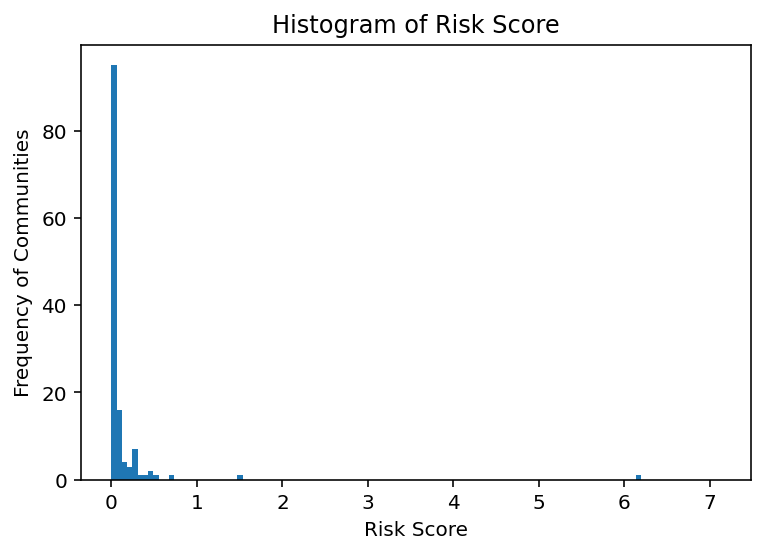

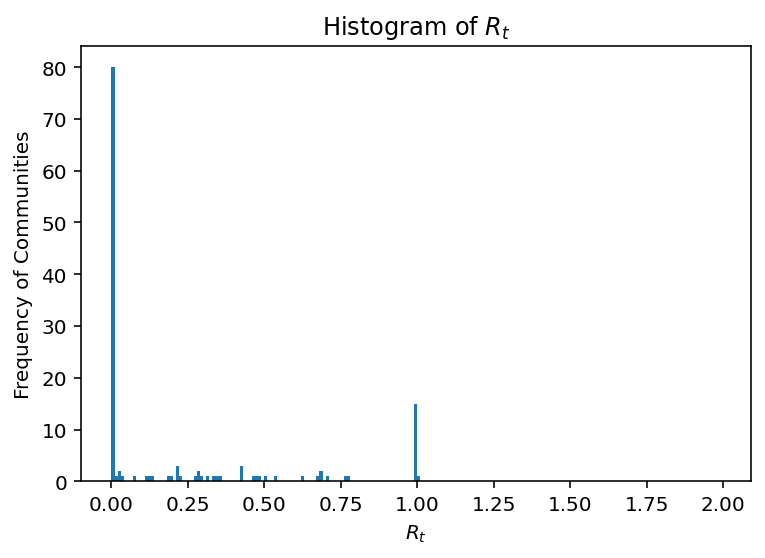

In [24]:
def main(num_day_for_moving_ave,top_i_comm, type_plot,Today_date,future_day_to_be_predicted,til_date,criteria, sigma,gamma):
	dict_county = {} # dictionary of all community objects
	list_communities = [] # list of all community objects
	list_pair = []			
	with open('lacounty_covid.json') as json_file:
		data = json.load(json_file)
		# record all data by creating community classes and fill out their variables 
		for day in sorted([int(k) for k in data.keys()]):
			if day < Today_date :
				#print(day, Today_date )
				for i in range(len(data[str(day)])):
					actual_name_of_community = 	data[str(day)][i][0].strip()
					name_of_community = data[str(day)][i][0].strip().lower().replace(' ','')
					# cleaning city names, removing following prefixes
					prefixex = ['cityof','losangeles-','unincorporated-']
					for word in prefixex:
						name_of_community = name_of_community.replace(word,'') 
					# cleaning confirmed number, e.g. <1 will be 1
					confirmed_cases   = data[str(day)][i][0].strip().lower(),re.sub("[^0-9]", "", data[str(day)][i][1].strip())
					if name_of_community not in dict_county.keys():
						dict_county[name_of_community] = community(name_of_community,actual_name_of_community,Today_date)
						list_communities.append(dict_county[name_of_community ])  
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))
					else:
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))


               
		dict_comm_for_update_csv = {}                        
		# get daily cases of all communities because the cumulative is already obtained
		for communiuty_obj in list_communities:
			dict_comm_for_update_csv[communiuty_obj.name] = communiuty_obj
			for index in range(len(communiuty_obj.confirmed)):
				if index == 0:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index]
				else:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index] - communiuty_obj.confirmed[index-1]	

###==============================================================================        
# active for community-wise        
		list_selected_communities=[]
		for comm in list_communities:
			for word in ['westhollywood','eastlosangeles','sanpedro','castaic']:
				if comm.name in word:
					list_selected_communities.append(comm)
# 		print(len(list_selected_communities))
# 		for comm in list_selected_communities:
# 			print(comm.actual_name)
# 		return  0        
###==============================================================================


		top_i_comm = len(list_communities)
		dict_key_comm_obj_val_inf_rate = {}        
		# find communiuty with highest 
		list_selected_communities = []
		days = list(range(1,Today_date-16+1))
		newlist = sorted(list_communities,key=lambda x: x.confirmed[-1], reverse=True)
		for en,communiuty_obj in enumerate(newlist):
			if communiuty_obj.name != '-investigatedcases' and communiuty_obj.name !='-underinvestigation'and top_i_comm > 0:
				# append this city to the list
				if check_if_community_is_in_dic_pop(communiuty_obj.actual_name):
					list_selected_communities.append(communiuty_obj)
					dict_key_comm_obj_val_inf_rate[communiuty_obj] = []
					#plt.plot(days, communiuty_obj.plot_info(type_plot),'o-',label = communiuty_obj.actual_name)
					top_i_comm -= 1


		#create_csv_file(list_selected_communities)
		# create matrix of I for top communities (highest number of confirmed cases)
		# matrix_I is matrix I for top communities until "til_date" (for training)
		# matrix_I = create_matrix(list_selected_communities, type_plot,til_date)
		# ref_matrix_I is matrix I for top communities for all days 				

		############################################################
		############### Set population for each comm ###############
		for communiuty_obj in list_selected_communities:
			communiuty_obj.set_population(get_population_vec([communiuty_obj])[0])
			#print(communiuty_obj.name,communiuty_obj.pop)

		############################################################
		############### smoothing infected cases for each comm ######   
		for communiuty_obj in list_selected_communities:
			communiuty_obj.smoothing(num_day_for_moving_ave)
			#print(communiuty_obj.name,communiuty_obj.confirmed_daily)

            
		############################################################
		############### calculating R for each comm ######   
		for communiuty_obj in list_selected_communities:
			communiuty_obj.set_infection_rate(sigma,mean_k,cap_for_searching_exact_sol)
			#print(communiuty_obj.name,communiuty_obj.infection_rate)            

		############################################################
		############### setting previous days risk for each comm ###### 
		day_pred_map = 83
		for communiuty_obj in list_selected_communities:
			for ind_day in range(day_pred_map):
				val = (10000)*(communiuty_obj.infection_rate[ind_day]*communiuty_obj.confirmed_daily[ind_day])/(communiuty_obj.pop-communiuty_obj.confirmed_daily[ind_day])
				communiuty_obj.set_risk(ind_day,max(0,val))
			print("=====")               
			print("bf",communiuty_obj.risk[82])
			pred = pred_R_LA(communiuty_obj.actual_name,communiuty_obj.risk[np.newaxis,:83] ,82,7,1)            
			##communiuty_obj.set_risk(ind_day)
			print("af",pred)
			communiuty_obj.set_risk(ind_day,max(0,pred))
			#return 0
			#print(communiuty_obj.name,communiuty_obj.infection_rate)             
		############################################################

            
            
            
                
  
		clear_output(wait=True)
		histogram_risk_score(list_communities)
		histogram_R_val(list_communities)
		return 0 
# 		##hist_thresholds = histogram_risk_score(list_communities)
		hist_thresholds = [-1.0,.05,1,2]#[-1.0,.1,1,2]
		#update_csv_file(dict_comm_for_update_csv,hist_thresholds)
		#update_csv_file_PREDICTION(dict_comm_for_update_csv,hist_thresholds)
		#return 0  



        
        
if __name__ == "__main__":
	num_day_for_moving_ave = 14
	top_k_community_with_highest_confirmed = 3 
	# Display mode: daily or cumulative
	display_mode = 'cumulative'
	number_of_days_passed_from_16th = 99 - 16 + 1	
	number_of_days_passed_from_16th_used_for_prediction =39
	future_day_to_be_predicted = 1
	criteria = 'train'
	# SEIR model 
	# 1-exp(-1/d_I) where d_I is 3-7
	sigma = 1.0/7.5 # 5.2
	gamma = 1.0/(2.3) 
	""" all_lag_indices represent the lags in the model, it should be a list of increamental numbers (min number is 1), 
	i.g. [1,3] means using times slots information of t-1 and t-3"""
	#all_lag_indices = [1]
	main(num_day_for_moving_ave,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,number_of_days_passed_from_16th_used_for_prediction,criteria,sigma,gamma)
        